In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from numba import jit
import seaborn as sns
import pandas as pd


path_figs = "./Figs/"

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

def set_figure_style(scale="1col"):
    """
    Set figure styling based on publication constraints.
    
    Parameters:
        scale (str): Scale of the figure, choose from "1col", "1.5col", "2col".
                     - "1col" for 8.5cm
                     - "1.5col" for 11.6cm
                     - "2col" for 17.6cm
    """
    # Define width options in cm
    widths = {"1col": 8.5, "1.5col": 11.6, "2col": 17.6}
    
    if scale not in widths:
        raise ValueError("Invalid scale. Choose from '1col', '1.5col', or '2col'.")
    
    # Convert width from cm to inches (1 cm = 0.393701 inches)
    width_in = widths[scale] * 0.393701
    
    # Set figure size (width, height)
    # Assuming height proportional to width (Golden Ratio)
    golden_ratio = (5**0.5 - 1) / 2
    rcParams["figure.figsize"] = (width_in, width_in * golden_ratio)
    
    # Set font sizes
    # rcParams["font.size"] = 10  # General font size
    rcParams["font.size"] = 20  # General font size
    # rcParams["axes.titlesize"] = 12  # Figure title
    rcParams["axes.titlesize"] = 26  # Figure title
    # rcParams["axes.labelsize"] = 9  # Axis main label
    rcParams["axes.labelsize"] = 22  # Axis main label
    # rcParams["xtick.labelsize"] = 7  # Tick labels
    rcParams["xtick.labelsize"] = 16  # Tick labels
    # rcParams["ytick.labelsize"] = 7
    rcParams["ytick.labelsize"] = 16
    # rcParams["legend.fontsize"] = 8  # Legend entries
    rcParams["legend.fontsize"] = 20  # Legend entries
    rcParams["figure.titleweight"] = "bold"
    
    # Set stroke width
    # rcParams["axes.linewidth"] = 0.75
    rcParams["axes.linewidth"] = 1.5

    rcParams["lines.linewidth"] = 3
    
    # rcParams["xtick.major.width"] = 0.75
    rcParams["xtick.major.width"] = 1.5
    # rcParams["ytick.major.width"] = 0.75
    rcParams["ytick.major.width"] = 1.5

    
    # Subpanel lettering size
    rcParams["text.usetex"] = False  # Set to True if using LaTeX
    rcParams["axes.formatter.use_mathtext"] = True  # Math text for scientific notation

def add_subpanel_label(ax, label, fontsize=20, position=(-0.1, 1.05)):
    """
    Add a subpanel label (e.g., 'a', 'b') to a subplot.
    
    Parameters:
        ax (Axes): Matplotlib Axes object.
        label (str): The label text.
        fontsize (int): Font size for the label.
        position (tuple): Position of the label in axes coordinates.
    """
    ax.text(position[0], position[1], label, transform=ax.transAxes, 
            fontsize=fontsize, fontweight="bold", va="top", ha="left")

###
set_figure_style(scale="1col")




In [3]:
finger_colors = {
    1: sns.color_palette('colorblind')[0],
    2: 'black',
    3: 'black',
    4: 'black',
    5: sns.color_palette('colorblind')[5],
}
finger_alphas = {
    1: 1,
    2: 0.5,
    3: 0.5,
    4: 0.5,
    5: 1,
}

In [4]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [16]:
np.array(sns.color_palette('colorblind')[2]) * 255

array([  2., 158., 115.])

In [5]:
sns.set_palette("colorblind")

In [6]:
visual_drift_coef = 1
# memory_drift_coef = 0.6 (This worked previously!)
memory_drift_coef = 0.7

def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = visual_drift_coef


    return result


def calc_memory_drifts(specific_seq, seq_length):
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = memory_drift_coef


    return result


seq = '1'
specific_seq = '1'
rand_seq = '5'


seq_length = len(seq)
window_sizes = [1,2,3,4,11]

visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

visual_delay = 90
motor_delay = 50

# diffusion = 5  (it worked previously!)
diffusion = 3
threshold = 350
alpha = 0.9985
# beta = 0.0015
# beta = 0.003
beta = 0.005
# alpha = 0.9995
# alpha = 0.999
# beta = 0.0005
# beta = 0.00005
# beta = 0.001
# beta = 0.005

In [7]:
@jit(nopython=True)
def get_planning_coefs(strategy, capacity, param):
    if strategy == 0:
        return exp_normalized_planning_jit(capacity, param)
    elif strategy == 1:
        return inv_normalized_planning_jit(capacity)
    else:
        raise ValueError("Unknown strategy")

@jit(nopython=True)
def exp_normalized_planning_jit(capacity, param):
    x = np.arange(capacity)
    theta = np.exp(-x * np.log(param))
    theta /= np.sum(theta)
    return theta

@jit(nopython=True)
def inv_normalized_planning_jit(capacity):
    x = np.arange(capacity)
    theta = 1 / (x + 1)
    theta /= np.sum(theta)
    return theta
def check_evidence_to_seq(evidence, seq):
    for press in range(len(seq)):
        if ~(np.argmax(evidence[:, press]) + 1 == int(seq[press])):
            return False
    return True

def calculate_IPI_from_press_time(press_times):

   return [press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))]

In [8]:
@jit(nopython=True)
def simulate_ddm_damping_lateral(seq, specific_seq, visual_drifts, memory_drifts, 
                                 diffusion, threshold, dt, max_time, seq_length, 
                                 window_size, planning_capacity, planning_param, planning_strategy, 
                                 visual_delay, motor_delay, alpha, beta):
    evidence = np.zeros((5, seq_length))
    time = 0
    visual_delay_queue = np.zeros(min(window_size, seq_length, planning_capacity))
    motor_delay_queue = np.zeros(0)
    current_press_planned = 0
    current_press_execed = 0
    effective_planning_capacity = 0
    effective_planning_capacity_motor = min(seq_length - current_press_planned, planning_capacity)
    visible_window_size = 0

    planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, seq_length, total_steps)

    t_index = 0

    press_times = np.full(seq_length, np.nan)

    A = np.eye(5) * alpha - np.full((5,5), beta) + np.eye(5) * beta


    while time < max_time - dt:
        time += dt
        visual_delay_queue += dt
        if len(motor_delay_queue) > 0:
            motor_delay_queue[0] += dt
        t_index += 1

        evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
        evidence[:, current_press_planned:] += diffusion_term * random_terms[:, current_press_planned:, t_index]

        for press in range(current_press_planned, min(current_press_planned + visible_window_size, seq_length, current_press_planned + planning_capacity)):
            evidence[:, press] += planning_coefs[press - current_press_planned] * drifts_visual_dt[:, press]

        for press in range(current_press_planned, min(seq_length, current_press_planned + effective_planning_capacity_motor)):
            evidence[:, press] += drifts_memory_dt[:, press]

        evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])

        if (evidence[:, current_press_planned: current_press_planned + 1] >= threshold).any():
            visible_window_size -= 1
            current_press_planned += 1
            motor_delay_queue = np.append(motor_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)

        if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= motor_delay:
            motor_delay_queue = motor_delay_queue[1:]
            visual_delay_queue = np.append(visual_delay_queue, 0)
            press_times[current_press_execed] = time
            current_press_execed += 1
            if current_press_execed == seq_length:
                break

        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    return press_times, evidence

In [9]:
class DriftDiffusionModel_Optimzied_damping_lateral:
    def __init__(self, seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt = 1, max_time = 10000,
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3,  
                 planning_strategy = 0, visual_delay = visual_delay, motor_delay = motor_delay, alpha = 0.99, beta = 0.005):
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert visual_drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.visual_drifts = visual_drifts 
        self.memory_drifts = memory_drifts
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
        self.motor_delay = motor_delay
        self.seq = seq
        self.specific_seq = specific_seq
        self.alpha = alpha
        self.beta = beta
    

    def simulate(self):
        press_times, evidence = simulate_ddm_damping_lateral(self.seq, self.specific_seq, self.visual_drifts, self.memory_drifts, 
                                                             self.diffusion, self.threshold, self.dt, self.max_time, 
                                                             self.seq_length, self.window_size, self.planning_capacity, 
                                                             self.planning_param, self.planning_strategy, self.visual_delay, self.motor_delay, self.alpha, self.beta)
        self.press_times = press_times
        return calculate_IPI_from_press_time(self.press_times), evidence
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for the specified number of simulations.

        Parameters:
        num_simulations (int): Number of simulations to plot.
        """ 
        
        fig, axs = plt.subplots(self.seq_length)
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length, self.planning_capacity))
        motor_delay_queue = np.array([])
        current_press_planned = 0
        current_press_execed = 0
        effective_planning_capacity = 0
        effective_planning_capacity_motor = min(self.seq_length - current_press_planned, self.planning_capacity)
        planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
        visible_window_size = 0

        press_times = np.full(self.seq_length, np.nan)
        A = np.eye(5) * self.alpha - np.full((5,5), self.beta) + np.eye(5) * self.beta

        total_steps = int(self.max_time / self.dt)

        random_terms = np.random.randn(5, seq_length ,total_steps)


        while time < self.max_time - self.dt:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            if len(motor_delay_queue) > 0:
                motor_delay_queue[0] += self.dt

            evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
            evidence[:, current_press_planned:] += self.diffusion * np.sqrt(self.dt) * random_terms[:, current_press_planned:, t_index]

            for press in range(current_press_planned, min(current_press_planned + visible_window_size, self.seq_length,current_press_planned + self.planning_capacity)):
                for finger in range(5):
                    evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt 

            for press in range(current_press_planned, min(seq_length, current_press_planned + effective_planning_capacity_motor)):
                for finger in range(5):
                    evidence[finger, press] += self.memory_drifts[finger, press] * self.dt

            evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])
            evidence_over_time[:, : ,t_index] = evidence[:, :]
            

            if (evidence[:, current_press_planned: current_press_planned + 1] >= self.threshold).any():
                visible_window_size -= 1
                current_press_planned += 1
                motor_delay_queue = np.append(motor_delay_queue, 0)
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)

            if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= self.motor_delay:
                motor_delay_queue = motor_delay_queue[1:]
                visual_delay_queue = np.append(visual_delay_queue, 0)
                press_times[current_press_execed] = time
                current_press_execed += 1
                if current_press_planned == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 
            
                    

        for press in range(self.seq_length):
            for finger in range(5):
                # axs.plot(np.arange(0, np.round(time, 2), self.dt)[:-motor_delay], evidence_over_time[finger, press, :t_index - motor_delay], 
                #          label = f'Finger {finger+1}', color = 'black', alpha = 0.5)
                axs.plot(np.arange(0, np.round(time, 2), self.dt)[:-motor_delay], evidence_over_time[finger, press, :t_index - motor_delay], 
                         label = f'Finger {finger+1}', color = finger_colors[finger+1], alpha = finger_alphas[finger+1])
                
            axs.set_xlim([0, np.round(time, 2)])
            axs.axhline(y = self.threshold, color = 'black', linestyle = '--')
            axs.set_xlabel('Time (a.u.)')
            axs.set_ylabel('Evidence (a.u.)')
            # axs.legend()
            # axs.axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            # # axs[press].set_ylabel('Evidence')
            # axs.set_xticks(np.append(axs.get_xticks(), press_times[press]))

            # axs.set_title(f'Press {press + 1}')
    

        # fig.supylabel('Evidence (a.u.)')
        return fig

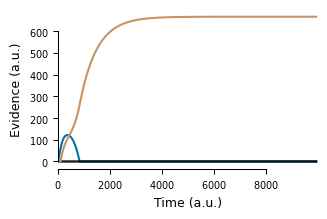

In [1066]:
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)


model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion = 0, threshold = np.inf, visual_delay=visual_delay, motor_delay=motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta= beta)
model.plot_simulations()
sns.despine(trim=True)


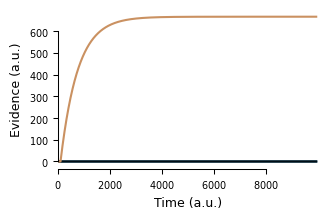

In [1067]:
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = np.zeros((5, seq_length))


model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion = 0, threshold = np.inf, visual_delay=visual_delay, motor_delay=motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta= beta)
model.plot_simulations()
sns.despine(trim=True)


In [1068]:
### Incongruent single press simulation RT (expecting specific, getting random) 

n_sims = 1000
RTs = np.array([])
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold = threshold, visual_delay=visual_delay, motor_delay = motor_delay,  
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    if check_evidence_to_seq(evidence, rand_seq):
        RTs = np.append(RTs, ipis[0])
    # RTs = np.append(RTs, ipis[0])

print(RTs.mean(), RTs.std())
print(len(RTs))

905.1346389228886 300.8797569448472
817


In [1069]:
### Incongruent single press simulation ACC (expecting random, getting specific)
n_sims = 1000
RTs = np.array([])
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold = threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs = np.append(RTs, check_evidence_to_seq(evidence, rand_seq))

print(RTs.mean(), RTs.std() / np.sqrt(n_sims))

0.819 0.0121753439376471


In [1071]:
### Incongruent single press simulation ACC in infinity (expecting random, getting specific)
n_sims = 1000
RTs = np.array([])
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs = np.append(RTs, check_evidence_to_seq(evidence, rand_seq))

print(RTs.mean(), RTs.std())

0.805 0.39620070671315066


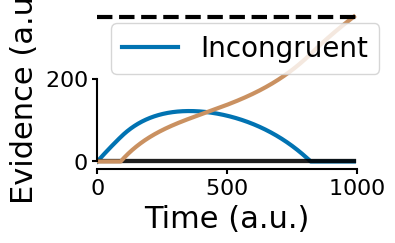

In [14]:
### Incongruent single press simulation

visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion = 0, threshold = threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)
model.plot_simulations()
plt.xlim(0, 1000)
label = 'Incongruent'
plt.legend([label], loc='upper left')
sns.despine(trim=True)
plt.savefig(path_figs + "single_press_incongruent.pdf", format = 'pdf', bbox_inches = 'tight')


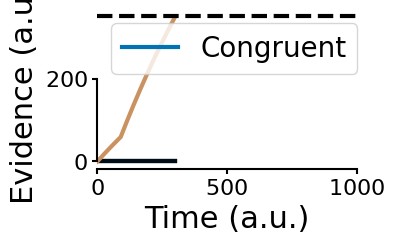

In [15]:
### congruent single press simulation

visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(rand_seq, seq_length)

model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, rand_seq, visual_drifts, memory_drifts, 
                                      diffusion = 0, threshold = threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)
model.plot_simulations()
plt.xlim(0, 1000)
label = 'Congruent'
plt.legend([label], loc='upper left')
sns.despine(trim=True)
plt.savefig(path_figs + "single_press_congruent.pdf", format = 'pdf', bbox_inches = 'tight')

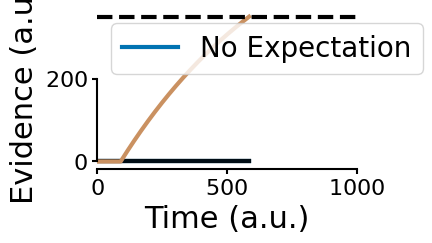

In [16]:
### random single press simulation 

visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = np.zeros((5, seq_length))

model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, rand_seq, visual_drifts, memory_drifts, 
                                      diffusion = 0, threshold = threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)
model.plot_simulations()
plt.xlim(0, 1000)
# set legend label
label = 'No Expectation'
plt.legend([label], loc='upper left')
sns.despine(trim = True)
plt.savefig(path_figs + "single_press_rand.pdf", format = 'pdf', bbox_inches = 'tight')

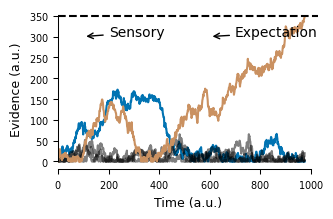

In [1045]:
### Incongruent single press simulation with noise

visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion = diffusion, threshold = threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)
model.plot_simulations()

plt.annotate('Sensory', xy=(100, 300), xytext=(200, 300),
             arrowprops=dict(facecolor='black', arrowstyle = '->', lw = 1),
             )

plt.annotate('Expectation', xy=(600, 300), xytext=(700, 300),
             arrowprops=dict(facecolor='black', arrowstyle = '->', lw = 1),
             )


sns.despine(trim=True)
plt.savefig(path_figs + "single_press_incongruent_noise.pdf", format = 'pdf', bbox_inches = 'tight')


In [1046]:
### congruent single press simulation RT  (expecting specific, getting specific)

n_sims = 1000
RTs = np.array([])
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs= np.append(RTs, ipis[0])

print(RTs.mean(), RTs.std())

391.813 70.34224926031297


In [836]:
### congruent single press simulation ACC  (expecting specific, getting specific)

n_sims = 1000
RTs = np.array([])
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs = np.append(RTs, check_evidence_to_seq(evidence, specific_seq))

print(RTs.mean(), RTs.std())

1.0 0.0


In [1079]:
### random single press simulation RT  (expecting random, getting random)
n_sims = 1000
RTs = np.array([])
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = np.zeros((5, seq_length))
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold = threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    if check_evidence_to_seq(evidence, rand_seq):
        RTs = np.append(RTs, ipis[0])
print(RTs.mean(), RTs.std())
print(len(RTs))



# ### congruent single press simulation RT  (expecting specific, getting specific)

# n_sims = 1000
# RTs = np.array([])
# visual_drifts = calc_visual_drifts(specific_seq, seq_length)
# memory_drifts = calc_memory_drifts(specific_seq, seq_length)
# model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
#                                       diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
#                                       planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

# for sim in range(n_sims):
#     ipis, evidence = model.simulate()
#     RTs = np.append(ipis[0], RTs)

# print(RTs.mean(), RTs.std())

678.203 114.20236333368938
1000


In [11]:
custom_palette = {
    'M': sns.color_palette('colorblind')[0],
    'No Expectation': sns.color_palette('colorblind')[7],
    'Congruent': sns.color_palette('colorblind')[1],
    'Incongruent': sns.color_palette('colorblind')[3]
}


/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_96552/4181320886.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data = RTs, x = 'condition', y = 'RT', errorbar='sd', linestyles='', palette = custom_palette)


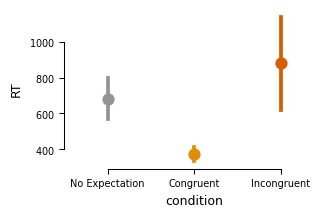

In [ ]:
### random single press simulation RT  (expecting random, getting random)
n_sims = 1000
RTs = np.array([])
RTs = pd.DataFrame(columns=['condition', 'RT'])
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = np.zeros((5, seq_length))
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    if check_evidence_to_seq(evidence, rand_seq):
        RTs.loc[len(RTs)] = ['No Expectation', ipis[0]]


### congruent single press simulation RT  (expecting specific, getting specific)

n_sims = 1000
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    if check_evidence_to_seq(evidence, specific_seq):
        RTs.loc[len(RTs)] = ['Congruent', ipis[0]]


### incongruent single press simulation RT  (expecting specific, getting random)
n_sims = 1000
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    if check_evidence_to_seq(evidence, rand_seq):
        RTs.loc[len(RTs)] = ['Incongruent', ipis[0]]


sns.pointplot(data = RTs, x = 'condition', y = 'RT', errorbar='sd', linestyles='', palette = custom_palette)
sns.despine(trim = True)
plt.savefig(path_figs + "single_press_conditions_RT.pdf", format = 'pdf', bbox_inches = 'tight')

/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_96552/3439968121.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data = RTs, x = 'condition', y = 'isError', errorbar='se', linestyles='', palette = custom_palette)


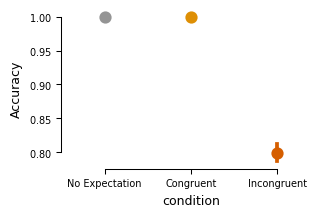

In [1088]:
### random single press simulation RT  (expecting random, getting random)
n_sims = 1000
RTs = np.array([])
RTs = pd.DataFrame(columns=['condition', 'isError'])
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = np.zeros((5, seq_length))
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs.loc[len(RTs)] = ['No Expectation', check_evidence_to_seq(evidence, rand_seq)]


### congruent single press simulation RT  (expecting specific, getting specific)

n_sims = 1000
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs.loc[len(RTs)] = ['Congruent', check_evidence_to_seq(evidence, specific_seq)]



### incongruent single press simulation RT  (expecting specific, getting random)
n_sims = 1000
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs.loc[len(RTs)] = ['Incongruent', check_evidence_to_seq(evidence, rand_seq)]



sns.pointplot(data = RTs, x = 'condition', y = 'isError', errorbar='se', linestyles='', palette = custom_palette)
plt.ylabel('Accuracy')
sns.despine(trim = True)
plt.savefig(path_figs + "single_press_conditions_ER.pdf", format = 'pdf', bbox_inches = 'tight')

/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_12439/2044240395.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


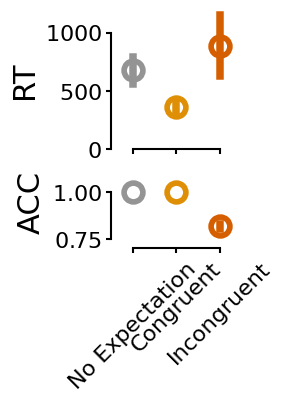

In [89]:
set_figure_style(scale="1col")

fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2], 'hspace' : 0.05}, sharex=True)
# fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(2, 3))
fig.set_size_inches(fig.get_size_inches()[0]/2, fig.get_size_inches()[1] * 1.5)




# ----------- Reaction Time -----------

### random single press simulation RT  (expecting random, getting random)
n_sims = 1000
RTs = np.array([])
RTs = pd.DataFrame(columns=['condition', 'RT'])
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = np.zeros((5, seq_length))
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    if check_evidence_to_seq(evidence, rand_seq):
        RTs.loc[len(RTs)] = ['No Expectation', ipis[0]]


### congruent single press simulation RT  (expecting specific, getting specific)

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    if check_evidence_to_seq(evidence, specific_seq):
        RTs.loc[len(RTs)] = ['Congruent', ipis[0]]


### incongruent single press simulation RT  (expecting specific, getting random)
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    if check_evidence_to_seq(evidence, rand_seq):
        RTs.loc[len(RTs)] = ['Incongruent', ipis[0]]


sns.pointplot(data = RTs, x = 'condition', y = 'RT', errorbar='sd', linestyles='', palette = custom_palette,
              hue = 'condition',ax = ax0)
#removing x axis ticks and labels
# ax0.xaxis.set_major_locator(ticker.NullLocator())
# plt.gca().xaxis.set_major_locator(ticker.NullLocator())
# plt.xlabel('')
ax0.set_xlabel(None)
#remove x axis line
ax0.spines['bottom'].set_visible(False)
# ax0.xaxis.set_major_locator(ticker.NullLocator())


# ----------- Error Rate -----------

### random single press simulation RT  (expecting random, getting random)
RTs = np.array([])
RTs = pd.DataFrame(columns=['condition', 'isError'])
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = np.zeros((5, seq_length))
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs.loc[len(RTs)] = ['No Expectation', check_evidence_to_seq(evidence, rand_seq)]


### congruent single press simulation RT  (expecting specific, getting specific)
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs.loc[len(RTs)] = ['Congruent', check_evidence_to_seq(evidence, specific_seq)]



### incongruent single press simulation RT  (expecting specific, getting random)
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs.loc[len(RTs)] = ['Incongruent', check_evidence_to_seq(evidence, rand_seq)]



sns.pointplot(data = RTs, x = 'condition', y = 'isError', errorbar='se', linestyles='', palette = custom_palette, 
              hue = 'condition', ax = ax1)

for artist in ax0.findobj(match=plt.Line2D):
    if artist.get_marker() != 'None':
        artist.set_markerfacecolor('white')

# Make sure the dots are hollow
for artist in ax1.findobj(match=plt.Line2D):
    if artist.get_marker() != 'None':
        artist.set_markerfacecolor('none')  # hollow circle


plt.xticks(rotation=45)
ax1.set_xlabel(None)
ax1.set_ylim([0.7,1.2])
ax0.set_ylim([0, 1200])
# plt.ylabel('Accuracy')
plt.ylabel('ACC')
#remove x axis line
# plt.gca().spines['bottom'].set_visible(False)
#removing x axis ticks and labels
# plt.gca().xaxis.set_major_locator(ticker.NullLocator())

sns.despine(trim = True)

plt.tight_layout()
plt.savefig(path_figs + "single_press_conditions_RT_and_ER.pdf", format = 'pdf', bbox_inches = 'tight')



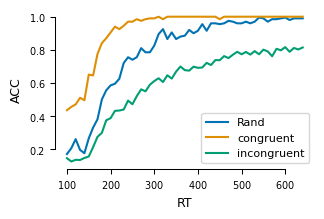

In [841]:
### forced reaction time simulation 

accs = []
for max_time in np.arange(50, 600, step = 10):    
    n_sims = 200
    RTs = np.array([])
    visual_drifts = calc_visual_drifts(rand_seq, seq_length)
    memory_drifts = np.zeros((5, seq_length))
    model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay = motor_delay,
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta, max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        RTs = np.append(RTs, check_evidence_to_seq(evidence, rand_seq))
    accs.append(RTs.mean())

plt.plot(np.arange(50 + motor_delay,600 + motor_delay, step = 10), accs, label = 'Rand')

accs = []
for max_time in np.arange(50, 600, step = 10):    
    n_sims = 200
    RTs = np.array([])
    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    model = DriftDiffusionModel_Optimzied_damping_lateral(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay = motor_delay,
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta, max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        RTs = np.append(RTs, check_evidence_to_seq(evidence, specific_seq))
    accs.append(RTs.mean())

plt.plot(np.arange(50 + motor_delay,600 + motor_delay, step = 10), accs, label = 'congruent')


accs = []
for max_time in np.arange(50, 600, step = 10):    
    n_sims = 1000
    RTs = np.array([])
    visual_drifts = calc_visual_drifts(rand_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay = motor_delay,
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta, max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        RTs = np.append(RTs, check_evidence_to_seq(evidence, rand_seq))
    accs.append(RTs.mean())

plt.plot(np.arange(50 + motor_delay,600 + motor_delay, step = 10), accs, label = 'incongruent')


plt.xlabel('RT')
plt.ylabel('ACC')
plt.legend()
sns.despine(trim = True)
plt.show()

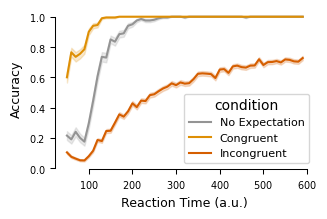

In [1085]:
### forced reaction time simulation 

accs = pd.DataFrame(columns = ['condition', 'RT', 'is_correct'])
for max_time in np.arange(50, 600, step = 10):    
    n_sims = 200
    visual_drifts = calc_visual_drifts(rand_seq, seq_length)
    memory_drifts = np.zeros((5, seq_length))
    model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay = motor_delay,
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta, max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        accs.loc[len(accs)] = ['No Expectation', max_time, check_evidence_to_seq(evidence, rand_seq)]


for max_time in np.arange(50, 600, step = 10):    
    n_sims = 200
    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    model = DriftDiffusionModel_Optimzied_damping_lateral(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay = motor_delay,
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta, max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        accs.loc[len(accs)] = ['Congruent', max_time, check_evidence_to_seq(evidence, specific_seq)]

for max_time in np.arange(50, 600, step = 10):    
    n_sims = 1000
    # RTs = np.array([])
    visual_drifts = calc_visual_drifts(rand_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay = motor_delay,
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta, max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        accs.loc[len(accs)] = ['Incongruent', max_time, check_evidence_to_seq(evidence, rand_seq)]

sns.lineplot(data = accs, x = 'RT', y = 'is_correct', hue = 'condition', palette = custom_palette, errorbar='se')
plt.ylabel('Accuracy')
plt.xlabel('Reaction Time (a.u.)')
sns.despine(trim=True)
# plt.savefig(path_figs + "forced_reaction_time_model.pdf", format = 'pdf', bbox_inches = 'tight')


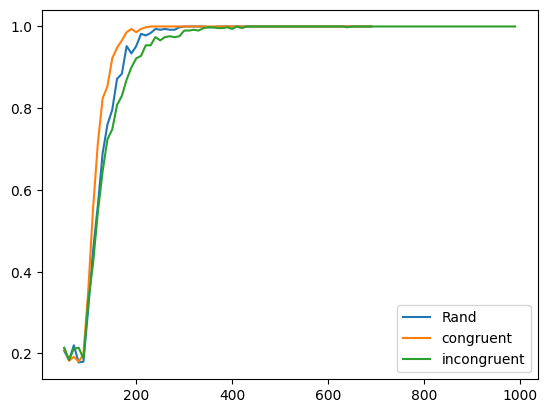

In [12]:
### free reaction time simulation

accs = []
for max_time in np.arange(50, 700, step = 10):    
    n_sims = 500
    RTs = np.array([])
    visual_drifts = calc_visual_drifts(rand_seq, seq_length)
    memory_drifts = np.zeros((5, seq_length))
    model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold, visual_delay=visual_delay, motor_delay=motor_delay, 
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta= beta, max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        RTs = np.append(RTs, check_evidence_to_seq(evidence, rand_seq))
    accs.append(RTs.mean())

plt.plot(np.arange(50,700, step = 10), accs, label = 'Rand')

accs = []
for max_time in np.arange(50, 700, step = 10):    
    n_sims = 500
    RTs = np.array([])
    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    model = DriftDiffusionModel_Optimzied_damping_lateral(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold, visual_delay=visual_delay, motor_delay=motor_delay, 
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta,  max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        RTs = np.append(RTs, check_evidence_to_seq(evidence, specific_seq))
    accs.append(RTs.mean())

plt.plot(np.arange(50,700, step = 10), accs, label = 'congruent')


accs = []
for max_time in np.arange(50, 1000, step = 10):    
    n_sims = 500
    RTs = np.array([])
    visual_drifts = calc_visual_drifts(rand_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold, visual_delay=visual_delay, motor_delay=motor_delay, 
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta, max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        RTs = np.append(RTs, check_evidence_to_seq(evidence, rand_seq))
    accs.append(RTs.mean())

plt.plot(np.arange(50,1000, step = 10), accs, label = 'incongruent')



plt.legend()
plt.show()

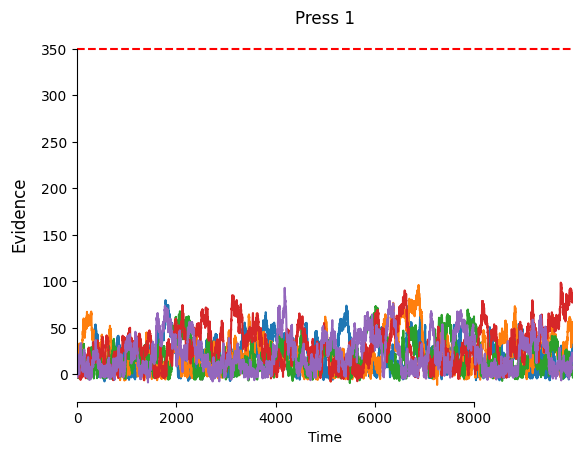

In [10]:
# Noise only simulation 

visual_drifts = np.zeros((5, seq_length))

memory_drifts = np.zeros((5, seq_length))

model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, rand_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta=beta)
model.plot_simulations()
sns.despine(trim=True)


In [127]:
### Noise only simulation RT

n_sims = 1000
RTs = np.array([])
visual_drifts = np.zeros((5, seq_length))

memory_drifts = np.zeros((5, seq_length))
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs = np.append(RTs, ~(evidence >= threshold).any())

print(RTs.mean(), RTs.std())

1.0 0.0
